# Feature Engineering
Based on our observations from the Exploratory Data Analysis, some of the features need to be transformed before they're ready to be run through the Logistic Regression.

In [ ]:
from pyspark.sql.functions import row_number, monotonically_increasing_id
from pyspark.sql import Window
from pyspark.sql import SQLContext
from pyspark.sql import types
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

## Daypart

The README specifies that the records are in chronological order.  Can we figure out a way to capitalize on this?

In [146]:
# The test set covers 1 day.  How many records are there in it?
test_RDD = sc.textFile("gs://w261-final-hoky/data/test.txt")
test_RDD.count()

6042135

So for one day of ad clicks in chronological order, we can see that it's about 6m records.  Now if we pull just the click column from the train set, we can look to see if there's a recurring pattern every ~6m records (obviously it will vary a bit day-to-day).

In [147]:
days_RDD = train_RDD.map(lambda x: x.split("\t")) \
                    .flatMap(lambda x: x[0])

days = days_RDD.collect()
days = list(map(int, days))

Now we have a list of ~45m 0s and 1s, representing clicks.  Create a function to bin them together so we can plot them.

In [148]:
def binplot(clicks, bins):
    binlist = []
    binsize = int(len(clicks)/bins)
    for x in range(bins):
        thisbin = np.sum(clicks[x*binsize:(x+1)*binsize])
        binlist.append(thisbin)
    return binlist

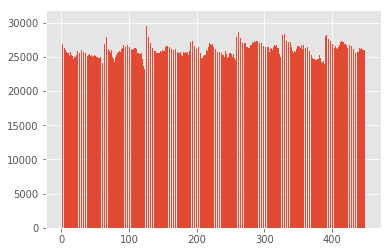

<Figure size 1440x1280 with 0 Axes>

In [149]:
# Putting the clicks into 450 bins will show us groups of ~10k rows per bar
bin24 = binplot(days, 450)
plt.bar(x=np.arange(len(bin24)), height=bin24)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.show()

Pulling the smallest bins, we can combine this with visual inspection to figure out the daily breakpoints

In [150]:
sorted_bin = bin24.copy()
sorted_bin.sort()
bottom = sorted_bin[:70]
indices = []
for x in bottom:
    indices.append(bin24.index(x))
indices.sort()

From this, we can discern the approximate breakpoints from one day to another: [63, 122, 189, 258, 324, 389].  Now we can load the data as a dataframe and create the daypart column.

In [3]:
# Load data into dataframe
train_df = spark.read.option("header", "false").parquet("gs://w261-final-hoky/data/scrubbed_train_data/")

In [5]:
train_df.take(1)

[Row(label=0, I1=0, I2=1, I3=292, I4=0, I5=4233, I6=612, I7=53, I8=9, I9=119, I10=0, I11=7, I12=0, I13=8, C1='05db9164', C2='207b2d81', C3='d52980aa', C4='b66d15e3', C5='4cf72387', C6='7e0ccccf', C7='07d03e2a', C8='ba7cbdc6', C9='a73ee510', C10='2462946f', C11='7f8ffe57', C12='b519c595', C13='46f42a63', C14='07d13a8f', C15='0c67c4ca', C16='7c8ae841', C17='27c07bd6', C18='395856b0', C19='21ddcdc9', C20='a458ea53', C21='605305ee', C22='C22_no_value', C23='32c7478e', C24='f090fae7', C25='001f3601', C26='fb1dfe3b')]

In [6]:
# Add an index column with sequential ID
indexed_df = train_df.withColumn("index", row_number().over(Window.orderBy(monotonically_increasing_id()))-1).cache()

In [7]:
def make_time(idx):
    '''Compare the index value to a set of breakpoints to assign a daypart to each record'''
    division = 24 # Number of partitions for each day
    breakpoints = [0, 63, 122, 189, 258, 324, 389, 458.40617]
    for b in range(len(breakpoints)):
        try:
            # How many rows should be in each daypart?
            increment = ((breakpoints[b+1]*100000)-(breakpoints[b]*100000))/division
            # Establish the breakpoints for the day
            sub_breakpoints = [(breakpoints[b]*100000)+(i*increment) for i in range(division)]
            sub_breakpoints.append(breakpoints[b+1]*100000)

            if idx > (breakpoints[b]*100000) and idx <= (breakpoints[b+1]*100000):
                print(sub_breakpoints)
                # We're in a day, now assign the daypart
                for b2 in range(len(sub_breakpoints)):
                    if idx > sub_breakpoints[b2] and idx <= sub_breakpoints[b2+1]:
                        return b2
        except IndexError:
            return breakpoints[b]*100000

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
maketime_udf = udf(lambda z: make_time(z), IntegerType())

In [ ]:
# Apply UDF to the dataset, and write out a modified dataset
start = time.time()
daypart_df = indexed_df.withColumn("daypart", maketime_udf('index')).cache()
daypart_df.write.format("parquet").save("gs://w261-final-hoky/data/daypart_train_data/")
print(f"... completed job in {time.time() - start} seconds")

## NAs, Binarization, Standardization